In [1]:
import torch
from torch.autograd import Variable
dtype = torch.FloatTensor

In [2]:
import numpy as np
pi = np.pi

In [3]:
%matplotlib notebook
import matplotlib.pyplot as plt

## Simultaneous search for policy and verifying Lyapunov function

$$\dot{x} = f(x,u)$$

$$ u = \pi_\theta(x)) $$

$$ V(x) = p.s.d. \text{by construction, but parameterized by parameters } \psi $$

$$ \dot{V} = \frac{dV}{dx} \dot{x}$$
$$ = \big[ \frac{dV}{dx}\big]^T \big[f(x,\pi_{\theta}(x) \big] $$

### Loss function

$X$ = {$x_1, x_2, ..., x_N$} many samples

$$ L(\theta) = \sum_{i} l(x_i, \theta) $$

\begin{equation}
  \mathcal{l}(x_i,\theta) =
  \begin{cases}
    \dot{V}(x_i, \theta) & \text{if $\dot{V}(x_i, \theta) > 0$} \\
    0 & \text{otherwise}
  \end{cases}
\end{equation}



In [4]:
x_i = Variable(torch.FloatTensor([1.0, 1.1]).type(dtype), requires_grad=True)
print x_i

P = Variable(torch.FloatTensor([1, 1]).type(dtype), requires_grad=True)
print P
### Step 1: compute V(x)
def compute_V(x):
    '''V(x) = x_1^2 + x_2^2'''
    x_squared = x.pow(2)
    return torch.dot(P, x_squared)

print x_i.shape
print compute_V(x_i)
x_i_2 = Variable(torch.FloatTensor([1.1, 2.2]).type(dtype), requires_grad=True)
print compute_V(x_i_2)

many_x_i = Variable(torch.FloatTensor([[1.0, 1.1, 2.0],[1.1, 2.2, 3.0]]).type(dtype), requires_grad=True)

def compute_V_vectorized(x):
    x_squared = x.pow(2)
    P_transpose = torch.t(P.unsqueeze(1))
    return P_transpose.mm(x_squared)

print many_x_i
print compute_V_vectorized(many_x_i)

Variable containing:
 1.0000
 1.1000
[torch.FloatTensor of size 2]

Variable containing:
 1
 1
[torch.FloatTensor of size 2]

torch.Size([2])
Variable containing:
 2.2100
[torch.FloatTensor of size 1]

Variable containing:
 6.0500
[torch.FloatTensor of size 1]

Variable containing:
 1.0000  1.1000  2.0000
 1.1000  2.2000  3.0000
[torch.FloatTensor of size 2x3]

Variable containing:
  2.2100   6.0500  13.0000
[torch.FloatTensor of size 1x3]



In [5]:
### Step 2: compute dV/dx

### Step 3: initialize policy parameters
K = Variable(torch.FloatTensor([1, 2]).type(dtype), requires_grad=True)
print K

### Step 4: define dynamics function
def dynamics(x):
    xdot = Variable(torch.zeros(2).type(dtype))
    xdot[0] = x[1]
    xdot[1] = -torch.dot(K,x)
    return xdot
    
xdot = dynamics(x_i)
print xdot
print dynamics(x_i_2)

many_x_i = Variable(torch.FloatTensor([[1.0, 1.1, 2.0],[1.1, 2.2, 3.0]]).type(dtype), requires_grad=True)

def dynamics_vectorized(x):
    xdot = Variable(torch.zeros(2,x.shape[1]).type(dtype))
    xdot[0,:] = x[1,:]
    K_transpose = torch.t(K.unsqueeze(1))
    xdot[1,:] = -K_transpose.mm(x)
    return xdot
      
print many_x_i
print dynamics_vectorized(many_x_i)

Variable containing:
 1
 2
[torch.FloatTensor of size 2]

Variable containing:
 1.1000
-3.2000
[torch.FloatTensor of size 2]

Variable containing:
 2.2000
-5.5000
[torch.FloatTensor of size 2]

Variable containing:
 1.0000  1.1000  2.0000
 1.1000  2.2000  3.0000
[torch.FloatTensor of size 2x3]

Variable containing:
 1.1000  2.2000  3.0000
-3.2000 -5.5000 -8.0000
[torch.FloatTensor of size 2x3]



In [6]:
def compute_Vdot(x):
    V = compute_V(x)
#     print x.shape
#     print V.shape
#     print V
    V.backward(torch.ones(1).type(dtype),retain_graph=True)
#     print "x.grad is", x.grad
    jacobian_x = Variable(x.grad.data)
#     print "jacobian_x is", jacobian_x
    f = dynamics(x)
    Vdot = torch.dot(jacobian_x,f)
    return Vdot

print "x_i is", x_i
if x_i.grad is not None:
    print x_i.grad.zero_()
Vdot = compute_Vdot(x_i)
print "Vdot is", Vdot
Vdot.backward()

def compute_Vdot_vectorized(x):
    V = compute_V_vectorized(x)
#     print V
#     print x.shape
#     print "x.grad is", x.grad
#    V.backward(torch.ones(1,1).type(dtype),retain_graph=True)
#     print x
    V.backward(torch.ones(1,x.shape[1]).type(dtype),retain_graph=True)
    jacobian_x = Variable(x.grad.data)
#     print "jacobian_x is", jacobian_x
    f = dynamics_vectorized(x)
    Vdot = (jacobian_x*f).sum(dim=0)
    return Vdot

print "many_x_i is", many_x_i

Vdot_vec = compute_Vdot_vectorized(many_x_i)
print Vdot_vec
#Vdot.backward(torch.ones(many_x_i.shape[1]).type(dtype))
cost = Vdot_vec.clamp(min=0).sum()
print cost
cost.backward()
many_x_i.grad.data.zero_()



x_i is Variable containing:
 1.0000
 1.1000
[torch.FloatTensor of size 2]

Vdot is Variable containing:
-4.8400
[torch.FloatTensor of size 1]

many_x_i is Variable containing:
 1.0000  1.1000  2.0000
 1.1000  2.2000  3.0000
[torch.FloatTensor of size 2x3]

Variable containing:
 -4.8400
-19.3600
-36.0000
[torch.FloatTensor of size 3]

Variable containing:
 0
[torch.FloatTensor of size 1]




 0  0  0
 0  0  0
[torch.FloatTensor of size 2x3]

## First let's verify, no synthesis
 
K = [1, 2] and P = [1, 1] should be stable

In [15]:
K = Variable(torch.FloatTensor([1, 2]).type(dtype), requires_grad=True)
P = Variable(torch.FloatTensor([1, 1]).type(dtype), requires_grad=True)
for i in range(10000):
    x_i = Variable(torch.randn(2).type(dtype), requires_grad=True)
    Vdot = compute_Vdot(x_i)
    if Vdot.data[0] > 0:
        print "false, counterexample found: ", x_i
        break

## Now let's search for K, from an initialization not stable

In [16]:
#P = Variable(torch.rand(2).type(dtype), requires_grad=True)
K = Variable(torch.randn(2).type(dtype), requires_grad=True)

print "Initial P", P
print "Initial K", K


for i in range(10000):
    x_i = Variable(torch.randn(2).type(dtype), requires_grad=True)
    Vdot = compute_Vdot(x_i)
    if Vdot.data[0] > 0:
        print "false, counterexample found: ", x_i
        break

Initial P Variable containing:
 1
 1
[torch.FloatTensor of size 2]

Initial K Variable containing:
-0.6560
-1.6455
[torch.FloatTensor of size 2]

false, counterexample found:  Variable containing:
 0.3539
 1.3432
[torch.FloatTensor of size 2]



In [20]:
# Reset 
K = Variable(torch.randn(2).type(dtype), requires_grad=True)
P = Variable(torch.FloatTensor([1, 1]).type(dtype), requires_grad=True)

<IPython.core.display.Javascript object>


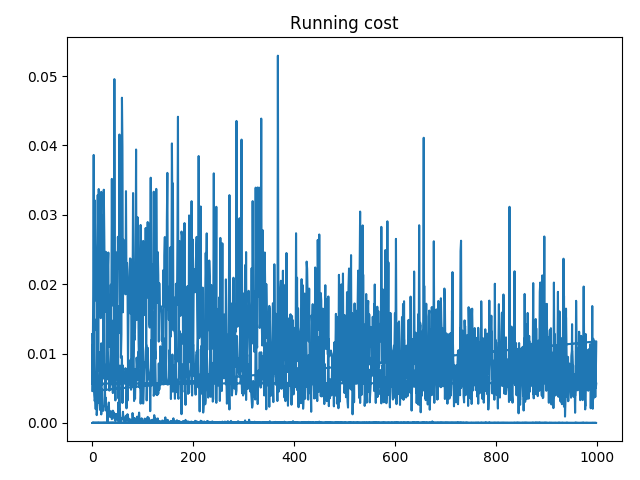

In [24]:
## optimization plotting tool

cost_current_iteration = 0
cost_history = []
cost_iteration_number_history = []

f, (cost_axis) = plt.subplots(1, 1)

cost_axis.plot(cost_iteration_number_history, cost_history)
cost_axis.set_title('Running cost')

plt.tight_layout()

In [33]:
## optimize

num_iterations = 1000
num_samples_per_iteration = 1000
step_rate = 1e-1

# K has already been initialized above, and initial policy visualized

import time
print "first P is", P
print "first K is", K

for cost_iteration in range(num_iterations):
    
    start = time.time()
    
    cost = 0
    
    many_x_i = Variable(torch.randn(2,10000).type(dtype), requires_grad=True)
    Vdot = compute_Vdot_vectorized(many_x_i)
    cost = Vdot.clamp(min=0).pow(2).sum()
        
    ## Automatically differentiate
    cost.backward()

    # Update K via gradient descent
    K.data -= step_rate * K.grad.data
    #P.data -= step_rate * P.grad.data
    
    # Project P into feasible
    #P.data = torch.abs(P.data)
    # Make P numerically stable by normalizing
    #P.data = P.data/P.data.sum()
      
    # Manually zero the gradients after running the backward pass
    K.grad.data.zero_()
    #P.grad.data.zero_()
    
    print time.time() - start, "is time for one step of grad descent"
    print 
    print cost.data[0]
    
    # handle plotting
    cost_history.append(cost.data[0])
    cost_iteration_number_history.append(cost_iteration)
    
    if cost_iteration % 100 == 0:
        cost_axis.lines[0].set_xdata(cost_iteration_number_history)
        cost_axis.lines[0].set_ydata(cost_history)
        cost_axis.relim()
        cost_axis.autoscale_view()
        cost_axis.figure.canvas.draw()
        
    if cost.data[0] == 0:
        break
        
    print "P is", P
    print "K is", K

first P is Variable containing:
 1
 1
[torch.FloatTensor of size 2]

first K is Variable containing:
 0.9796
 1.5486
[torch.FloatTensor of size 2]

0.0106341838837 is time for one step of grad descent

4.04914953833e-06
P is Variable containing:
 1
 1
[torch.FloatTensor of size 2]

K is Variable containing:
 0.9797
 1.5486
[torch.FloatTensor of size 2]

0.00362586975098 is time for one step of grad descent

4.90180082124e-06
P is Variable containing:
 1
 1
[torch.FloatTensor of size 2]

K is Variable containing:
 0.9798
 1.5486
[torch.FloatTensor of size 2]

0.00434684753418 is time for one step of grad descent

5.4678325796e-06
P is Variable containing:
 1
 1
[torch.FloatTensor of size 2]

K is Variable containing:
 0.9799
 1.5486
[torch.FloatTensor of size 2]

0.00431609153748 is time for one step of grad descent

6.50491347187e-06
P is Variable containing:
 1
 1
[torch.FloatTensor of size 2]

K is Variable containing:
 0.9801
 1.5486
[torch.FloatTensor of size 2]

0.0040271282196 is

0.00319004058838 is time for one step of grad descent

5.37018252089e-07
P is Variable containing:
 1
 1
[torch.FloatTensor of size 2]

K is Variable containing:
 0.9834
 1.5487
[torch.FloatTensor of size 2]

0.00289607048035 is time for one step of grad descent

9.18419743812e-07
P is Variable containing:
 1
 1
[torch.FloatTensor of size 2]

K is Variable containing:
 0.9834
 1.5487
[torch.FloatTensor of size 2]

0.00267195701599 is time for one step of grad descent

9.3696166914e-07
P is Variable containing:
 1
 1
[torch.FloatTensor of size 2]

K is Variable containing:
 0.9834
 1.5487
[torch.FloatTensor of size 2]

0.00266003608704 is time for one step of grad descent

1.41059115322e-06
P is Variable containing:
 1
 1
[torch.FloatTensor of size 2]

K is Variable containing:
 0.9835
 1.5487
[torch.FloatTensor of size 2]

0.00272607803345 is time for one step of grad descent

7.3103547038e-07
P is Variable containing:
 1
 1
[torch.FloatTensor of size 2]

K is Variable containing:
 0.9

0.00430417060852 is time for one step of grad descent

7.01287206084e-07
P is Variable containing:
 1
 1
[torch.FloatTensor of size 2]

K is Variable containing:
 0.9856
 1.5487
[torch.FloatTensor of size 2]

0.00427317619324 is time for one step of grad descent

1.22647918488e-06
P is Variable containing:
 1
 1
[torch.FloatTensor of size 2]

K is Variable containing:
 0.9856
 1.5487
[torch.FloatTensor of size 2]

0.00426816940308 is time for one step of grad descent

8.94841662102e-07
P is Variable containing:
 1
 1
[torch.FloatTensor of size 2]

K is Variable containing:
 0.9857
 1.5487
[torch.FloatTensor of size 2]

0.00424885749817 is time for one step of grad descent

6.16778265794e-07
P is Variable containing:
 1
 1
[torch.FloatTensor of size 2]

K is Variable containing:
 0.9857
 1.5487
[torch.FloatTensor of size 2]

0.00426483154297 is time for one step of grad descent

6.72156545534e-07
P is Variable containing:
 1
 1
[torch.FloatTensor of size 2]

K is Variable containing:
 0

K is Variable containing:
 0.9864
 1.5487
[torch.FloatTensor of size 2]

0.00337600708008 is time for one step of grad descent

2.82803057416e-07
P is Variable containing:
 1
 1
[torch.FloatTensor of size 2]

K is Variable containing:
 0.9864
 1.5487
[torch.FloatTensor of size 2]

0.00258684158325 is time for one step of grad descent

3.49632813368e-07
P is Variable containing:
 1
 1
[torch.FloatTensor of size 2]

K is Variable containing:
 0.9864
 1.5487
[torch.FloatTensor of size 2]

0.00469207763672 is time for one step of grad descent

6.72873511576e-07
P is Variable containing:
 1
 1
[torch.FloatTensor of size 2]

K is Variable containing:
 0.9864
 1.5487
[torch.FloatTensor of size 2]

0.00464987754822 is time for one step of grad descent

1.00200459485e-07
P is Variable containing:
 1
 1
[torch.FloatTensor of size 2]

K is Variable containing:
 0.9864
 1.5487
[torch.FloatTensor of size 2]

0.00439500808716 is time for one step of grad descent

6.33259787719e-07
P is Variable cont

0.00420498847961 is time for one step of grad descent

1.31414864768e-07
P is Variable containing:
 1
 1
[torch.FloatTensor of size 2]

K is Variable containing:
 0.9875
 1.5487
[torch.FloatTensor of size 2]

0.00508213043213 is time for one step of grad descent

9.82726987786e-07
P is Variable containing:
 1
 1
[torch.FloatTensor of size 2]

K is Variable containing:
 0.9875
 1.5487
[torch.FloatTensor of size 2]

0.00510096549988 is time for one step of grad descent

4.20612053631e-07
P is Variable containing:
 1
 1
[torch.FloatTensor of size 2]

K is Variable containing:
 0.9875
 1.5487
[torch.FloatTensor of size 2]

0.00471615791321 is time for one step of grad descent

2.03749749517e-07
P is Variable containing:
 1
 1
[torch.FloatTensor of size 2]

K is Variable containing:
 0.9876
 1.5487
[torch.FloatTensor of size 2]

0.00505399703979 is time for one step of grad descent

1.97962947368e-07
P is Variable containing:
 1
 1
[torch.FloatTensor of size 2]

K is Variable containing:
 0

0.00398397445679 is time for one step of grad descent

1.13617304009e-07
P is Variable containing:
 1
 1
[torch.FloatTensor of size 2]

K is Variable containing:
 0.9883
 1.5487
[torch.FloatTensor of size 2]

0.00281810760498 is time for one step of grad descent

8.10207382074e-07
P is Variable containing:
 1
 1
[torch.FloatTensor of size 2]

K is Variable containing:
 0.9883
 1.5487
[torch.FloatTensor of size 2]

0.00254106521606 is time for one step of grad descent

1.44471599128e-07
P is Variable containing:
 1
 1
[torch.FloatTensor of size 2]

K is Variable containing:
 0.9883
 1.5487
[torch.FloatTensor of size 2]

0.00265502929688 is time for one step of grad descent

3.47121584809e-07
P is Variable containing:
 1
 1
[torch.FloatTensor of size 2]

K is Variable containing:
 0.9884
 1.5487
[torch.FloatTensor of size 2]

0.00452184677124 is time for one step of grad descent

5.37557944824e-08
P is Variable containing:
 1
 1
[torch.FloatTensor of size 2]

K is Variable containing:
 0

0.00299406051636 is time for one step of grad descent

7.56558478088e-08
P is Variable containing:
 1
 1
[torch.FloatTensor of size 2]

K is Variable containing:
 0.9888
 1.5487
[torch.FloatTensor of size 2]

0.00244903564453 is time for one step of grad descent

6.45099120788e-08
P is Variable containing:
 1
 1
[torch.FloatTensor of size 2]

K is Variable containing:
 0.9888
 1.5487
[torch.FloatTensor of size 2]

0.00223708152771 is time for one step of grad descent

3.99705868404e-07
P is Variable containing:
 1
 1
[torch.FloatTensor of size 2]

K is Variable containing:
 0.9888
 1.5487
[torch.FloatTensor of size 2]

0.0022439956665 is time for one step of grad descent

1.58026182362e-07
P is Variable containing:
 1
 1
[torch.FloatTensor of size 2]

K is Variable containing:
 0.9888
 1.5487
[torch.FloatTensor of size 2]

0.00224304199219 is time for one step of grad descent

1.53923707558e-07
P is Variable containing:
 1
 1
[torch.FloatTensor of size 2]

K is Variable containing:
 0.

1.29853091835e-07
P is Variable containing:
 1
 1
[torch.FloatTensor of size 2]

K is Variable containing:
 0.9890
 1.5487
[torch.FloatTensor of size 2]

0.0024778842926 is time for one step of grad descent

3.94110458046e-07
P is Variable containing:
 1
 1
[torch.FloatTensor of size 2]

K is Variable containing:
 0.9891
 1.5487
[torch.FloatTensor of size 2]

0.00251603126526 is time for one step of grad descent

1.43542834508e-07
P is Variable containing:
 1
 1
[torch.FloatTensor of size 2]

K is Variable containing:
 0.9891
 1.5487
[torch.FloatTensor of size 2]

0.00249600410461 is time for one step of grad descent

7.80985871529e-08
P is Variable containing:
 1
 1
[torch.FloatTensor of size 2]

K is Variable containing:
 0.9891
 1.5487
[torch.FloatTensor of size 2]

0.00242495536804 is time for one step of grad descent

1.00601610598e-07
P is Variable containing:
 1
 1
[torch.FloatTensor of size 2]

K is Variable containing:
 0.9891
 1.5487
[torch.FloatTensor of size 2]

0.002419948

P is Variable containing:
 1
 1
[torch.FloatTensor of size 2]

K is Variable containing:
 0.9895
 1.5487
[torch.FloatTensor of size 2]

0.00259494781494 is time for one step of grad descent

7.94237777768e-08
P is Variable containing:
 1
 1
[torch.FloatTensor of size 2]

K is Variable containing:
 0.9895
 1.5487
[torch.FloatTensor of size 2]

0.00498294830322 is time for one step of grad descent

8.25321464504e-08
P is Variable containing:
 1
 1
[torch.FloatTensor of size 2]

K is Variable containing:
 0.9895
 1.5487
[torch.FloatTensor of size 2]

0.00489115715027 is time for one step of grad descent

1.11223357635e-07
P is Variable containing:
 1
 1
[torch.FloatTensor of size 2]

K is Variable containing:
 0.9895
 1.5487
[torch.FloatTensor of size 2]

0.00492906570435 is time for one step of grad descent

2.05298704259e-07
P is Variable containing:
 1
 1
[torch.FloatTensor of size 2]

K is Variable containing:
 0.9895
 1.5487
[torch.FloatTensor of size 2]

0.00425720214844 is time for

P is Variable containing:
 1
 1
[torch.FloatTensor of size 2]

K is Variable containing:
 0.9899
 1.5487
[torch.FloatTensor of size 2]

0.00267696380615 is time for one step of grad descent

1.19297098422e-07
P is Variable containing:
 1
 1
[torch.FloatTensor of size 2]

K is Variable containing:
 0.9899
 1.5487
[torch.FloatTensor of size 2]

0.00267100334167 is time for one step of grad descent

1.69439715592e-07
P is Variable containing:
 1
 1
[torch.FloatTensor of size 2]

K is Variable containing:
 0.9900
 1.5487
[torch.FloatTensor of size 2]

0.00265002250671 is time for one step of grad descent

7.21705077922e-08
P is Variable containing:
 1
 1
[torch.FloatTensor of size 2]

K is Variable containing:
 0.9900
 1.5487
[torch.FloatTensor of size 2]

0.00266695022583 is time for one step of grad descent

9.77154854809e-08
P is Variable containing:
 1
 1
[torch.FloatTensor of size 2]

K is Variable containing:
 0.9900
 1.5487
[torch.FloatTensor of size 2]

0.00266599655151 is time for

0.00317907333374 is time for one step of grad descent

5.39841025216e-08
P is Variable containing:
 1
 1
[torch.FloatTensor of size 2]

K is Variable containing:
 0.9903
 1.5487
[torch.FloatTensor of size 2]

0.00284790992737 is time for one step of grad descent

4.48817942811e-08
P is Variable containing:
 1
 1
[torch.FloatTensor of size 2]

K is Variable containing:
 0.9903
 1.5487
[torch.FloatTensor of size 2]

0.00280094146729 is time for one step of grad descent

4.27820943116e-08
P is Variable containing:
 1
 1
[torch.FloatTensor of size 2]

K is Variable containing:
 0.9903
 1.5487
[torch.FloatTensor of size 2]

0.0028030872345 is time for one step of grad descent

4.98204499877e-08
P is Variable containing:
 1
 1
[torch.FloatTensor of size 2]

K is Variable containing:
 0.9903
 1.5487
[torch.FloatTensor of size 2]

0.00280404090881 is time for one step of grad descent

5.69071190171e-08
P is Variable containing:
 1
 1
[torch.FloatTensor of size 2]

K is Variable containing:
 0.

0.00336003303528 is time for one step of grad descent

4.30666631246e-08
P is Variable containing:
 1
 1
[torch.FloatTensor of size 2]

K is Variable containing:
 0.9906
 1.5487
[torch.FloatTensor of size 2]

0.00271987915039 is time for one step of grad descent

3.59932812444e-08
P is Variable containing:
 1
 1
[torch.FloatTensor of size 2]

K is Variable containing:
 0.9906
 1.5487
[torch.FloatTensor of size 2]

0.00267219543457 is time for one step of grad descent

7.64009655541e-08
P is Variable containing:
 1
 1
[torch.FloatTensor of size 2]

K is Variable containing:
 0.9906
 1.5487
[torch.FloatTensor of size 2]

0.00268697738647 is time for one step of grad descent

3.95462897984e-08
P is Variable containing:
 1
 1
[torch.FloatTensor of size 2]

K is Variable containing:
 0.9906
 1.5487
[torch.FloatTensor of size 2]

0.00266909599304 is time for one step of grad descent

8.28737540814e-08
P is Variable containing:
 1
 1
[torch.FloatTensor of size 2]

K is Variable containing:
 0

0.00390601158142 is time for one step of grad descent

1.28707320357e-08
P is Variable containing:
 1
 1
[torch.FloatTensor of size 2]

K is Variable containing:
 0.9909
 1.5487
[torch.FloatTensor of size 2]

0.00277614593506 is time for one step of grad descent

4.55684876499e-08
P is Variable containing:
 1
 1
[torch.FloatTensor of size 2]

K is Variable containing:
 0.9909
 1.5487
[torch.FloatTensor of size 2]

0.00241303443909 is time for one step of grad descent

5.09363999868e-08
P is Variable containing:
 1
 1
[torch.FloatTensor of size 2]

K is Variable containing:
 0.9909
 1.5487
[torch.FloatTensor of size 2]

0.00220608711243 is time for one step of grad descent

5.0646754346e-08
P is Variable containing:
 1
 1
[torch.FloatTensor of size 2]

K is Variable containing:
 0.9909
 1.5487
[torch.FloatTensor of size 2]

0.0021960735321 is time for one step of grad descent

1.4785094038e-07
P is Variable containing:
 1
 1
[torch.FloatTensor of size 2]

K is Variable containing:
 0.99

0.00340104103088 is time for one step of grad descent

4.33476543549e-08
P is Variable containing:
 1
 1
[torch.FloatTensor of size 2]

K is Variable containing:
 0.9910
 1.5487
[torch.FloatTensor of size 2]

0.00270700454712 is time for one step of grad descent

1.68052309846e-07
P is Variable containing:
 1
 1
[torch.FloatTensor of size 2]

K is Variable containing:
 0.9911
 1.5487
[torch.FloatTensor of size 2]

0.00479388237 is time for one step of grad descent

1.02459239315e-07
P is Variable containing:
 1
 1
[torch.FloatTensor of size 2]

K is Variable containing:
 0.9911
 1.5487
[torch.FloatTensor of size 2]

0.00460815429688 is time for one step of grad descent

6.74873916751e-08
P is Variable containing:
 1
 1
[torch.FloatTensor of size 2]

K is Variable containing:
 0.9911
 1.5487
[torch.FloatTensor of size 2]

0.0040180683136 is time for one step of grad descent

7.32793168368e-08
P is Variable containing:
 1
 1
[torch.FloatTensor of size 2]

K is Variable containing:
 0.991

0.00411796569824 is time for one step of grad descent

6.35179944197e-08
P is Variable containing:
 1
 1
[torch.FloatTensor of size 2]

K is Variable containing:
 0.9912
 1.5487
[torch.FloatTensor of size 2]

0.00297808647156 is time for one step of grad descent

1.41123850383e-08
P is Variable containing:
 1
 1
[torch.FloatTensor of size 2]

K is Variable containing:
 0.9912
 1.5487
[torch.FloatTensor of size 2]

0.00245404243469 is time for one step of grad descent

6.83337901819e-08
P is Variable containing:
 1
 1
[torch.FloatTensor of size 2]

K is Variable containing:
 0.9912
 1.5487
[torch.FloatTensor of size 2]

0.00256514549255 is time for one step of grad descent

5.20593346209e-08
P is Variable containing:
 1
 1
[torch.FloatTensor of size 2]

K is Variable containing:
 0.9912
 1.5487
[torch.FloatTensor of size 2]

0.00245690345764 is time for one step of grad descent

9.10481201544e-09
P is Variable containing:
 1
 1
[torch.FloatTensor of size 2]

K is Variable containing:
 0

In [34]:
print K
print P

Variable containing:
 0.9914
 1.5487
[torch.FloatTensor of size 2]

Variable containing:
 1
 1
[torch.FloatTensor of size 2]



## Analytical double integrator Lyapunov

$$x = 
       \begin{bmatrix} x_1 \\ x_2
        \end{bmatrix} $$

$$\dot{x} = f(x,u) =
       \begin{bmatrix} x_2 \\ u
        \end{bmatrix} $$
        
Policy

$$ u = \pi_K(x) = -K^Tx = - k_1x_1 - k_2x_2$$
        
Lyapunov

$$V(x) = P^Tx = p_1x_1^2 + p_2x_2^2 = \text{p.s.d. by construction}$$

$$\dot{V}(x) = \bigg[ \frac{\partial V}{\partial x}\bigg]^T \big[f(x,\pi_K(x) \big] $$

$$ = \begin{bmatrix} 2p_1x_1 \\ 2p_2x_2
        \end{bmatrix}^T \begin{bmatrix} x_2 \\ -k_1x_1 - k_2x_2
        \end{bmatrix} $$
        
$$ =  2p_1x_1x_2 + 2p_2x_2( - k_1x_1 - k_2x_2) $$

$$ =  2p_1x_1x_2 - 2p_2k_1x_1x_2 - 2p_2k_2x_2^2 $$

We need both terms to be negative semidefinite:

$$ =  2x_1x_2(p_1 - p_2k_1 ) - 2p_2k_2x_2^2 $$

Therefore conditions are:

a) $p_1 = p_2k_1$

b) $k_2 > 0$ ($p_2$ already must be $> 0$) 

In [35]:
# condition (a):  p_1 - p_2*k_1
print P[0] - P[1]*K[0]

# condition (b): k_2 > 0
print K[1]


Variable containing:
1.00000e-03 *
  8.6335
[torch.FloatTensor of size 1]

Variable containing:
 1.5487
[torch.FloatTensor of size 1]



In [37]:
for i in range(10000):
    x_i = Variable(torch.randn(2).type(dtype), requires_grad=True)
    Vdot = compute_Vdot(x_i)
    if Vdot.data[0] > 0:
        print "false, counterexample found: ", x_i
        print i
        print Vdot.data[0]
        break

false, counterexample found:  Variable containing:
-0.8036
-0.0008
[torch.FloatTensor of size 2]

289
8.96665733308e-06


In [17]:
# Note: first time I ended up with these values:

# print K
# print P
# Variable containing:
#   0.2410
#  16.2734
# [torch.FloatTensor of size 2]

# Variable containing:
#  0.3484
#  0.8831
# [torch.FloatTensor of size 2]

#Which gave only:

# # condition (a):  p_1 - p_2*k_1
# print P[0] - P[1]*K[0]

# # condition (b): k_2 > 0
# print K[1]

# Variable containing:
#  0.1356
# [torch.FloatTensor of size 1]

# Variable containing:
#  16.2734
# [torch.FloatTensor of size 1]

# But this was Vdot negative semidefinite over all samples, since k_2 was so large it could outweigh the first term

In [18]:
state_tape = []
state_tape.append(state_initial)

for i in range(1000):
    u = dynamics(state_tape[-1])[1]
    next_state = double_integrator_next_state(state_tape[-1],u)
    state_tape.append(next_state)
    
print len(state_tape)
img_tape = []

for i in state_tape:
    img_tape.append(double_integrator_state_to_img(i))
    
print len(img_tape)

1001
1001


In [ ]:
    
ani = get_animation(img_tape)
HTML(ani.to_html5_video())